#### Prepared for Gabor's Data Analysis

### Data Analysis for Business, Economics, and Policy
by Gabor Bekes and  Gabor Kezdi
 
Cambridge University Press 2021

**[gabors-data-analysis.com ](https://gabors-data-analysis.com/)**

 License: Free to share, modify and use for educational purposes. 
 Not to be used for commercial purposes.

### Chapter 14
**CH14A Predicting used car value: log prices**

using the used-cars dataset

version 0.8 2021-07-15

In [21]:
import os
import sys
import warnings

import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
from plotnine import *
from stargazer import stargazer
from statsmodels.tools.eval_measures import mse, rmse
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import KFold
from math import sqrt


warnings.filterwarnings("ignore")
# turning off scientific notation
pd.set_option("display.float_format", lambda x: "%.2f" % x)

In [2]:
# DATA IMPORT
data = pd.read_csv("/workspaces/codespaces-jupyter/data/used-cars_2cities_prep.csv")
#data = pd.read_csv("https://osf.io/7gvz9/download")

In [3]:
# SAMPLE DESIGN

# Manage missing
data["fuel"] = data["fuel"].fillna("Missing")
data["condition"] = data["condition"].fillna("Missing")
data["drive"] = data["drive"].fillna("Missing")
data["cylinders"] = data["cylinders"].fillna("Missing")
data["transmission"] = data["transmission"].fillna("Missing")
data["type"] = data["type"].fillna("Missing")


In [4]:
# keep gas-fuelled vehicles
data = data.query("fuel=='gas'")

# drop vehicles in fair and new condition, trucks
data = data.query("condition not in ['new','fair']")

# drop unrealistic values for price and odometer reading
price_range = np.arange(500, 25001, 1)
data = data.query("price in @price_range").query("odometer<=100")

# drop if price is smaller than 1000 and condition is like new or age is less than 8
data = data.query("~(price < 1000 & (condition == 'like new'|age < 8))")

data = data.query("~(transmission=='manual')")

# drop if truck
data = data.query("~(type=='truck')")

# drop pricestr
data = data.drop(["pricestr"], axis=1)


In [5]:
# DATA GENERATION & DESCRIPTIVES
# CONDITION
data["cond_excellent"] = np.where(data["condition"] == "excellent", 1, 0)
data["cond_good"] = np.where(data["condition"] == "good", 1, 0)
data["cond_likenew"] = np.where(data["condition"] == "like new", 1, 0)
# cylinders
data["cylind6"] = np.where(data["cylinders"] == "6 cylinders", 1, 0)
data.cylinders.value_counts()
data.cylind6.value_counts()
# age: quadratic, cubic
data["agesq"] = data["age"] ** 2
data["agecu"] = data["age"] ** 3
# odometer quadratic
data["odometersq"] = data["odometer"] ** 3


In [6]:
# focus only on Chicago
data = data.query("area=='chicago'")

In [7]:
data["lnprice"]

0     8.52
2     9.61
3     9.66
4     6.75
6     7.38
      ... 
328   9.79
330   9.59
331   8.61
333   9.29
336   9.16
Name: lnprice, Length: 289, dtype: float64

### Compare Graphs
#### lowess:price

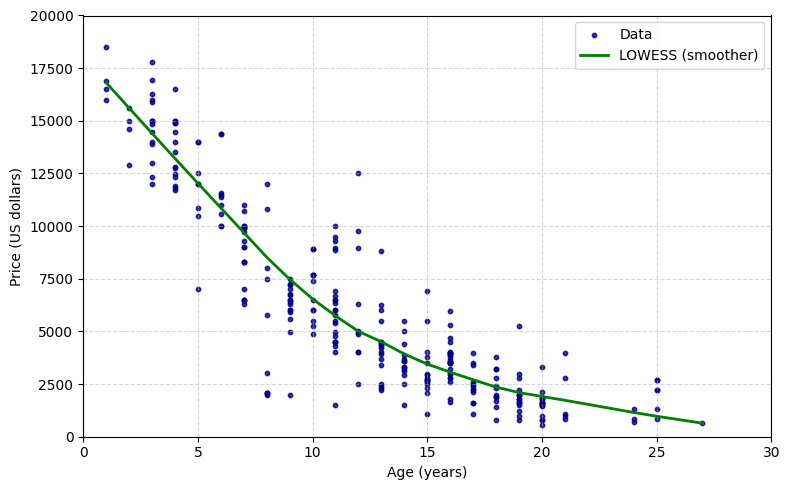

In [8]:
from statsmodels.nonparametric.smoothers_lowess import lowess
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.scatter(data["age"], data["price"], color="darkblue", s=10, alpha=0.8, label="Data")

# LOWESS smoothing using statsmodels
lowess_smoothed = lowess(data["price"], data["age"], frac=0.3)
plt.plot(lowess_smoothed[:, 0], lowess(data["price"], data["age"], frac=0.6)[:, 1], color="green", linewidth=2, label="LOWESS (smoother)")

plt.xlim(0, 30)
plt.ylim(0, 20000)
plt.xticks(range(0, 31, 5))
plt.yticks(range(0, 20001, 2500))
plt.xlabel("Age (years)")
plt.ylabel("Price (US dollars)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


#### lowess: lnprice

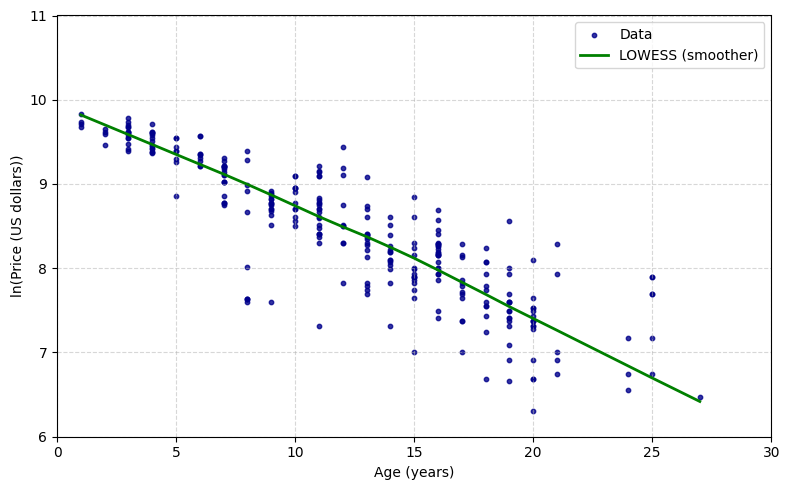

In [9]:
plt.figure(figsize=(8, 5))
plt.scatter(data["age"], data["lnprice"], color="darkblue", s=10, alpha=0.8, label="Data")

# LOWESS smoothing using statsmodels
lowess_smoothed = lowess(data["lnprice"], data["age"], frac=0.3)
plt.plot(lowess_smoothed[:, 0], lowess(data["lnprice"], data["age"], frac=0.6)[:, 1], color="green", linewidth=2, label="LOWESS (smoother)")

plt.xlim(0, 30)
plt.ylim(6, 11)
plt.xticks(range(0, 31, 5))
plt.yticks(range(6, 12, 1))
plt.xlabel("Age (years)")
plt.ylabel("ln(Price (US dollars))")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


---
### Linear regressions

In [10]:
model1 = "lnprice ~ age + agesq"
model2 = "lnprice ~ age + agesq + odometer"
model3 = "lnprice ~ age + agesq + odometer + odometersq + LE + cond_excellent + cond_good + dealer"
model4 = "lnprice ~ age + agesq + odometer + odometersq + LE + XLE + SE + cond_likenew + cond_excellent + cond_good + cylind6 + dealer"
model5 = "lnprice ~ age + agesq + odometer + odometersq + LE * age + XLE * age + SE * age + cond_likenew * age + cond_excellent * age + cond_good * age + cylind6 * age + odometer * age + dealer * age"

model_equations = [model1, model2, model3, model4, model5]

In [11]:
models = []
for equation in model_equations:
    models.append(smf.ols(equation, data).fit(cov_type="HC1"))

Use custom function `ols_crossvalidator`

In [12]:
help(ols_crossvalidator)

NameError: name 'ols_crossvalidator' is not defined

Set n_fold = 4 for 4-fold cross-validation

In [22]:
def ols_crossvalidator(equation, data, n_fold=4, average_rmse=False):
    kf = KFold(n_splits=4, shuffle=True, random_state=42)
    rmse_list = []

    for train_index, test_index in kf.split(data):
        train_data = data.iloc[train_index]
        test_data = data.iloc[test_index]

        model = smf.ols(equation, data=train_data).fit()
        y_pred = model.predict(test_data)
        y_true = test_data[equation.split("~")[0].strip()]

        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        rmse_list.append(rmse)

    if average_rmse:
        return np.mean(rmse_list)
    else:
        return rmse_list

In [23]:
n_fold = 4

In [24]:
cv_list = []
for equation in model_equations:
    result = ols_crossvalidator(equation, data, n_fold=4, average_rmse=False)
    cv_list.append(result)

Get statistics for models fitted on the whole dataframe

In [27]:
summary = pd.DataFrame({
    "Model": ["Model " + str(i + 1) for i in range(len(model_equations))],
    "Nvars": [1, 2, 5, 6, 6],  # adjust based on your actual model variables [1, 2, 5, 6, 6]
    "Coefficients": [len(models.params) for models in models],
    "R-squared": [models.rsquared for models in models],
    "RMSE": [np.mean(cv) for cv in cv_list],
    "BIC": [models.bic for models in models],
})

summary = summary[["Model", "Nvars", "Coefficients", "R-squared", "RMSE", "BIC"]]
summary.set_index("Model", inplace=True)
summary.round(2)


,Nvars,Coefficients,R-squared,RMSE,BIC
Model,,,,,
Model 1,1,3,0.77,0.40,289.74
Model 2,2,4,0.81,0.36,230.81
Model 3,5,9,0.83,0.35,239.21
Model 4,6,13,0.84,0.36,247.87
Model 5,6,22,0.85,0.36,275.47


Foldwise test RMSE-s

In [29]:
pd.DataFrame(
    cv_list,
    index=["Model " + str(i + 1) for i in range(len(cv_list))],
    columns=["Fold" + str(i + 1) for i in range(len(cv_list[0]))],
).assign(Average=lambda x: x.mean(axis=1)).T.round(2)

,Model 1,Model 2,Model 3,Model 4,Model 5
Fold1,0.42,0.38,0.37,0.38,0.38
Fold2,0.34,0.29,0.30,0.28,0.28
Fold3,0.39,0.35,0.34,0.35,0.35
Fold4,0.44,0.42,0.40,0.41,0.44
Average,0.40,0.36,0.35,0.36,0.36


### Prediction
---

In [30]:
new = pd.DataFrame(
    pd.Series(
        {
            "age": 10,
            "agesq": 10**2,
            "odometer": 12,
            "odometersq": 12**2,
            "SE": 0,
            "LE": 1,
            "XLE": 0,
            "cond_likenew": 0,
            "cond_excellent": 1,
            "cond_good": 0,
            "dealer": 0,
            "price": np.nan,
            "cylind6": 0,
        }
    )
).T
new


,age,agesq,odometer,odometersq,SE,LE,XLE,cond_likenew,cond_excellent,cond_good,dealer,price,cylind6
0,10.00,100.00,12.00,144.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,NaN,0.00


In [32]:
def point_predict_with_conf_int(model, new_data, interval_precision=0.8):
    """
    Returns point prediction and prediction interval for a new observation.
    Args:
        model: fitted statsmodels OLS regression result
        new_data: pandas DataFrame with a single row (new observation)
        interval_precision: confidence level for the interval (e.g., 0.8 for 80%)
    Returns:
        point_pred: float, point prediction
        (lower, upper): tuple, lower and upper bounds of the prediction interval
    """
    pred = model.get_prediction(new_data)
    summary_frame = pred.summary_frame(alpha=1 - interval_precision)
    point_pred = summary_frame["mean"].values[0]
    lower = summary_frame["obs_ci_lower"].values[0]
    upper = summary_frame["obs_ci_upper"].values[0]
    return point_pred, (lower, upper)

In [34]:
reg3 = models[2]

In [35]:
prediction = pd.DataFrame(
    [
        point_predict_with_conf_int(reg3, new, interval_precision=0.8),
    ],
    index=["Model in logs"],
).T

To recalculate predictions to level, we need to extract the rmse

In [36]:
rmse3 = rmse(reg3.fittedvalues, data["lnprice"])

Prediction in levels

In [39]:
log_point_prediction_new = prediction.iloc[0, 0]

In [40]:
level_point_prediction_new = np.exp(log_point_prediction_new) * np.exp(rmse3**2 / 2)

Prediction interval (log and level)

In [41]:
intervals = prediction.loc["Prediction Interval (80%)"].values[0]
log_lower_interval_prediction_new = intervals[0]
log_upper_interval_prediction_new = intervals[1]

KeyError: 'Prediction Interval (80%)'

In [ ]:
level_lower_interval_prediction_new = np.exp(
    log_lower_interval_prediction_new
) * np.exp(rmse3**2 / 2)
level_upper_interval_prediction_new = np.exp(
    log_upper_interval_prediction_new
) * np.exp(rmse3**2 / 2)

In [ ]:
prediction["Recalculated to level"] = [
    level_point_prediction_new,
    [
        round(level_lower_interval_prediction_new, 2),
        round(level_upper_interval_prediction_new, 2),
    ],
]

Add level model prediction

In [ ]:
levelreg3 = smf.ols(model3.replace("ln", ""),data).fit()

In [ ]:
prediction["Model in levels"] = point_predict_with_conf_int(levelreg3, new, interval_precision=0.8)

In [ ]:
prediction.loc["Prediction Interval (80%)", :] = prediction.loc[
    "Prediction Interval (80%)", :
].apply(format_confidence_interval)

### Table 14.1 Prediction with the model in log of $y$

In [ ]:
prediction

,Model in logs,Recalculated to level,Model in levels
Point prediction,8.56,5524.49,5359.32
Prediction Interval (80%),[8.11–9.01],[3522.57–8664.13],[3599.65–7118.99]
